<a href="https://colab.research.google.com/github/dilne/Fixing-OOM-in-TensorFlow/blob/main/NotebookAndGuide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Intro
OOM errors are the worst! You've got an idea for the coolest AI system, you collect the data, you process the data, you define the architecture, you go to train and you're met with an out of memory error...

Fear no more! If you have 10,000 images, just create ten new datasets comprising data from the original dataset. Train your model with the first dataset, save the model, wipe the model from memory, load the model, continue training with the second dataset, and repeat!

The following are demonstrated within this notebook:
- A dataset of 10,000 greyscale images is loaded. The images are a resolution of 1 x 1 for example purposes. If you used 10,000 greyscale images with 1024 x 1024 resolution and the model in this notebook, training should work up to approximately 12 GB VRAM.
- The dataset is split into train and test data
- The train dataset is split into segments
- The model is defined
- The model is complied
- The model is

In [1]:
import os
import gc
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras import models, layers
import tensorflow as tf
from tensorflow import keras

This is used to "only grow the memory usage as is needed by the process": https://www.tensorflow.org/guide/gpu

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

1 Physical GPUs, 1 Logical GPUs
GPU is available


### Set Variables

In [3]:
width = int(512)
height = int(512)
dims = (width, height)

### Load Data
The data in this GitHub Repository is only one image. We will fabricate a dataset of 10,000 images by loading it 10,000 times. To do this, we simply use the following line:
```
for i in range(10000):
```
It's worth noting for Google Colab users, that the following code will take the system RAM up to approximately 7 GB.



In [9]:
X = []
y = []

data_dir = "/content/"
for fname in sorted(os.listdir(data_dir)):
  for i in range(1000):
    if fname.endswith(".png") and not fname.startswith("."):
      path = os.path.join(data_dir, fname)
      feature = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
      X.append((feature/255.).astype(np.float32))
      y.append(np.int8(0))

In [10]:
X = np.array(X, copy=True)

In [11]:
y = np.array(y, copy=True)

In [12]:
np.save("Data\X.npy", X)
np.save("Data\y.npy", y)

In [13]:
X = np.load("Data\X.npy")
y = np.load("Data\y.npy")

In [14]:
print("X:")
print("Samples: {}, Type: {}, Shape: {}, Min: {}, Max: {}".format(len(X), X.dtype, X[0].shape, X.min(), X.max()))
print()
print("Y:")
print("Samples: {}, Type: {}".format(len(y), y.dtype))
print()
print(len(X))
print(len(y))

X:
Samples: 1000, Type: float32, Shape: (512, 512), Min: 0.21568627655506134, Max: 0.7843137383460999

Y:
Samples: 1000, Type: int8

1000
1000


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print('X_train: ', len(X_train))
print('y_train: ', len(y_train))
print('X_test:  ', len(X_test))
print('y_test:  ', len(y_test))

X_train:  750
y_train:  750
X_test:   250
y_test:   250


In [16]:
X_train_split = np.array_split(X_train, 10)
y_train_split = np.array_split(y_train, 10)
print(f"Length: {len(X_train_split)}")
print(f"Length of tenth: {len(X_train_split[0])}")

Length: 10
Length of tenth: 75


### Remove Unnecessary Variables

In [17]:
del X
del y
del X_train
del y_train
gc.collect()

83

### Define Model Function

In [18]:
def define_model():
  model = models.Sequential()
  model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(width, height, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(2, activation='softmax'))

  return(model)

### Compile Model Function

In [19]:
def compile_model(model):
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    
  return(model)

### Display Accuracy Function

In [20]:
  def display_accuracy(results):  
    x = np.empty((0))
    for i in range(num_epochs):
        x = np.append(x, i+1)
    fig, axis = plt.subplots(1, 2, figsize=(20, 5))
    axis[0].plot(x, results.history["loss"], color='r', label = 'train loss')
    axis[0].plot(x, results.history["val_loss"], color='b', label = 'val loss')
    axis[0].set_title('Loss Comparison')
    axis[0].legend()
    axis[0].set_ylim([0,0.1e-0])
    axis[1].plot(x, results.history["accuracy"], color='r', label = 'train accuracy')
    axis[1].plot(x, results.history["val_accuracy"], color='b', label = 'val accuracy')
    axis[1].set_title('Accuracy Comparison')
    axis[1].legend()
    axis[1].set_ylim([0.9, 1])
    plt.show()

### Define Callback

In [21]:
class SaveModelCallback(tf.keras.callbacks.Callback):
    def __init__(self, i):
        self.i = i
    
    def on_epoch_end(self, epoch, logs={}):
      if epoch == 9:
        global save_path_h5
        if i < 9: folder = "final"
        else: folder = "temp"
        save_path_h5 = f"\Model Saves\{folder}\h5\model_save.h5"
        model.save(save_path_h5)

        # you might want to save as .pb too,
        # but you can't load a pb to continue training
        # so it's only useful for a final model save
        # global save_path_pb
        # save_path_pb = f"\Model Saves\final\pb\model_save"
        # tf.saved_model.save(model, save_path_pb)

### Train Model

Run 1/10
Epoch 1/10
 5/38 [==>...........................] - ETA: 0s - loss: 0.1380 - accuracy: 1.0000  

38/38 [==============================] - 10s 38ms/step - loss: 0.0184 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
38/38 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
38/38 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
38/38 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
38/38 [==============================] - 1s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
38/38 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
38/38 [==============================] - 1s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.000

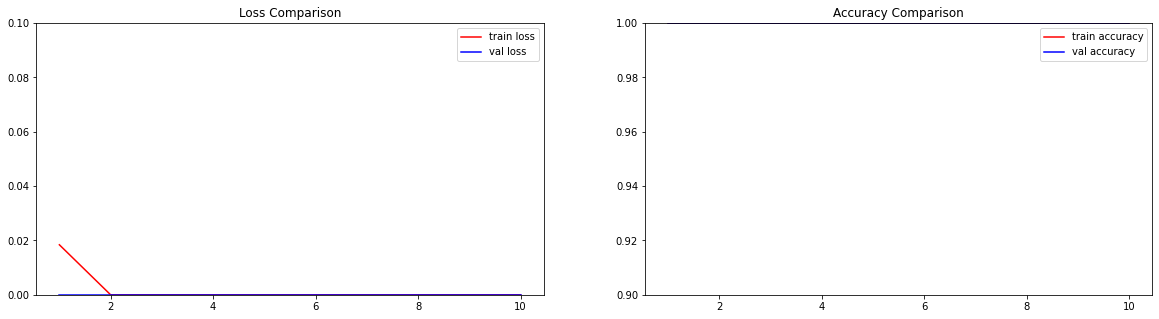


Run 2/10
Epoch 1/10
 4/38 [==>...........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000 

38/38 [==============================] - 2s 40ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
38/38 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
38/38 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
38/38 [==============================] - 1s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
38/38 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
38/38 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
38/38 [==============================] - 1s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.

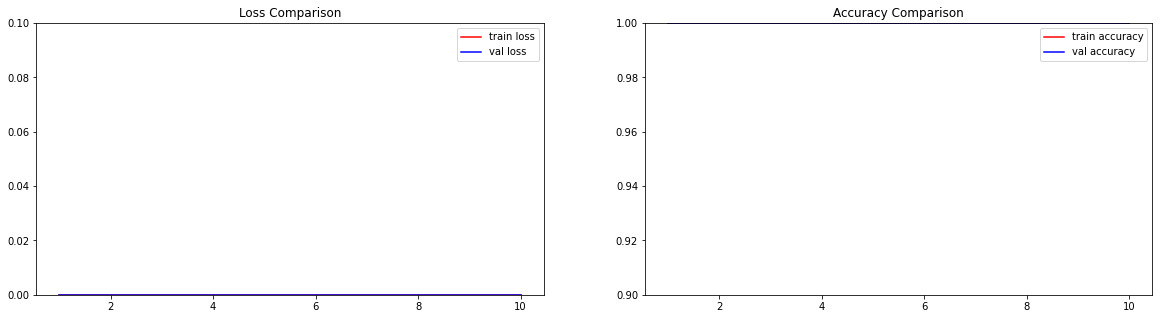


Run 3/10
Epoch 1/10
 4/38 [==>...........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000 

38/38 [==============================] - 2s 38ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
38/38 [==============================] - 1s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
38/38 [==============================] - 1s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
38/38 [==============================] - 1s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
38/38 [==============================] - 1s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
38/38 [==============================] - 1s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
38/38 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.

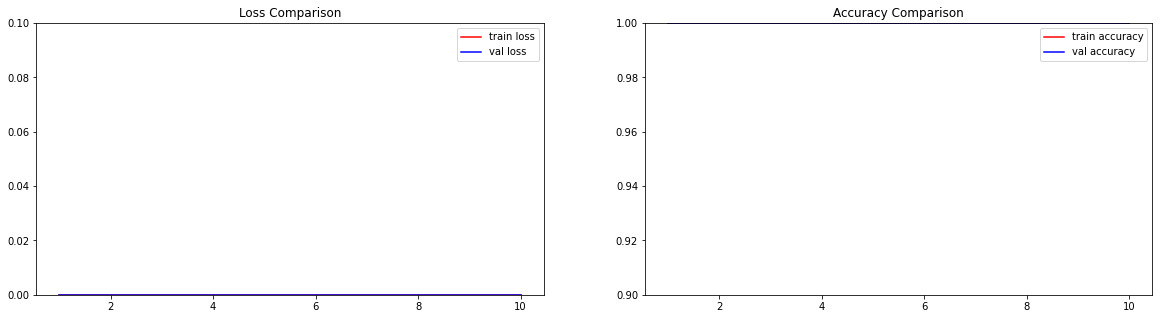


Run 4/10
Epoch 1/10
 4/38 [==>...........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000 

38/38 [==============================] - 2s 39ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
38/38 [==============================] - 1s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
38/38 [==============================] - 1s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
38/38 [==============================] - 1s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
38/38 [==============================] - 1s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
38/38 [==============================] - 1s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
38/38 [==============================] - 1s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.

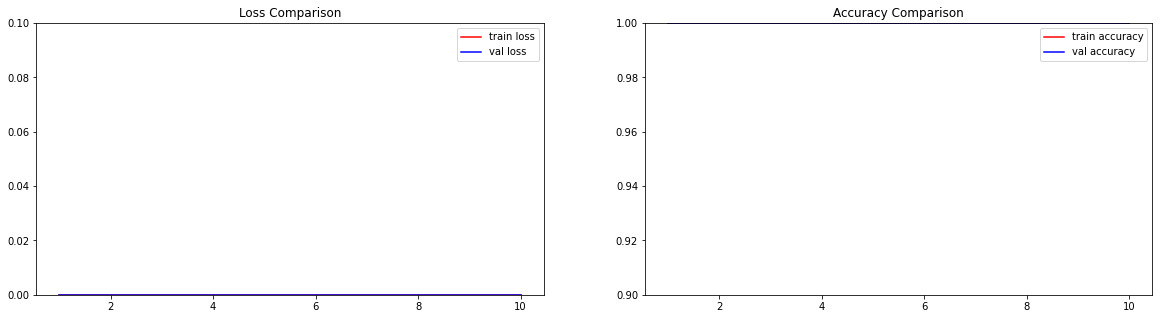


Run 5/10
Epoch 1/10
 4/38 [==>...........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000 

38/38 [==============================] - 2s 39ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
38/38 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
38/38 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
38/38 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
38/38 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
38/38 [==============================] - 1s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
38/38 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.

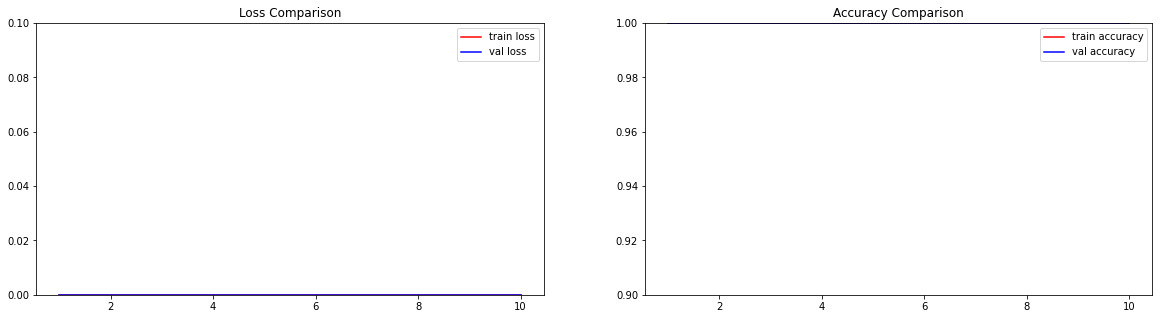


Run 6/10
Epoch 1/10
 4/38 [==>...........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000 

38/38 [==============================] - 2s 33ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
38/38 [==============================] - 1s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
38/38 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
38/38 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
38/38 [==============================] - 1s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
38/38 [==============================] - 1s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
38/38 [==============================] - 1s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.

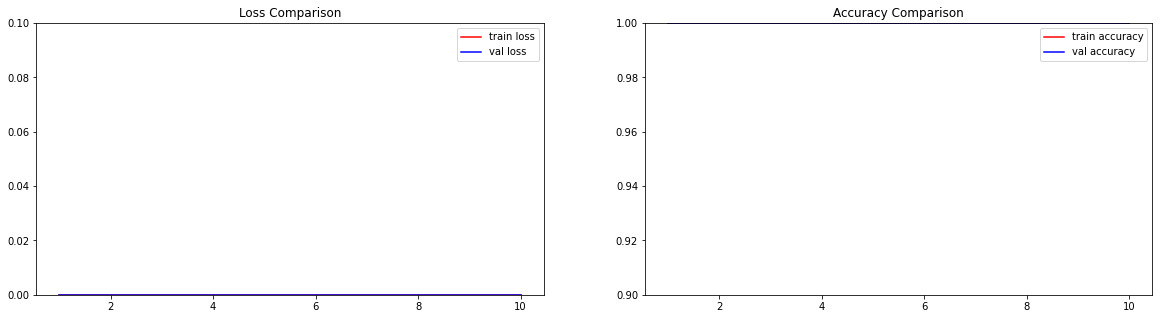


Run 7/10
Epoch 1/10
 4/38 [==>...........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000 

38/38 [==============================] - 2s 32ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
38/38 [==============================] - 1s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
38/38 [==============================] - 1s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
38/38 [==============================] - 1s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
38/38 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
38/38 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
38/38 [==============================] - 1s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.

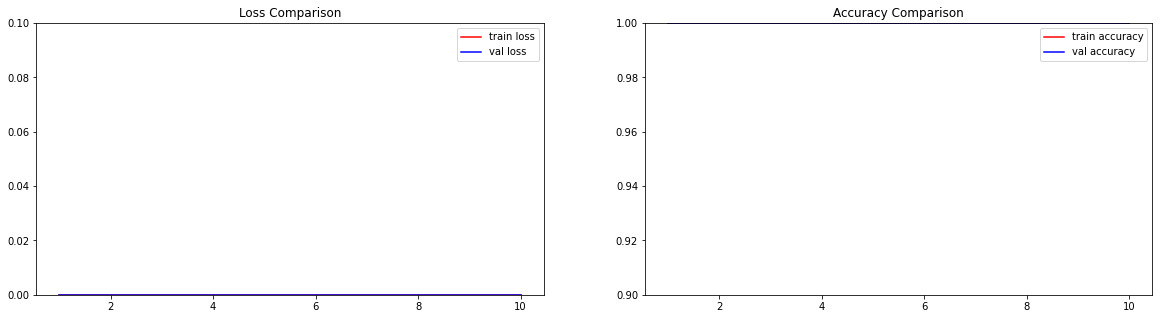


Run 8/10
Epoch 1/10
 4/38 [==>...........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000 

38/38 [==============================] - 2s 38ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
38/38 [==============================] - 1s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
38/38 [==============================] - 1s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
38/38 [==============================] - 1s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
38/38 [==============================] - 1s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
38/38 [==============================] - 1s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
38/38 [==============================] - 1s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.

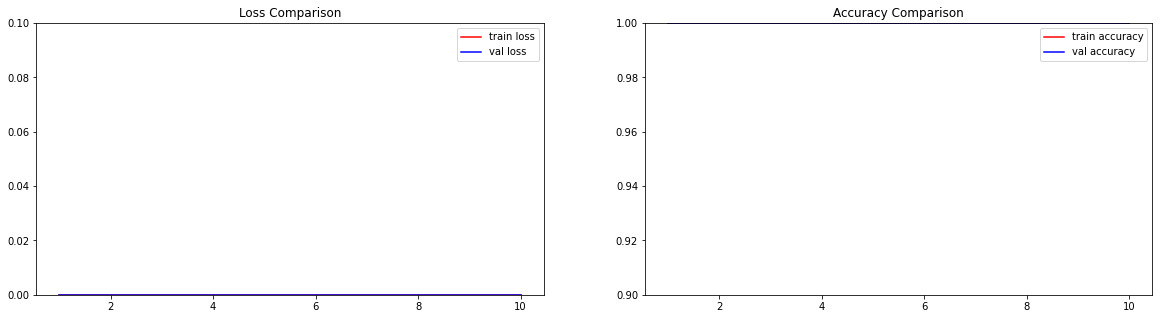


Run 9/10
Epoch 1/10
 4/38 [==>...........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000 

38/38 [==============================] - 2s 34ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
38/38 [==============================] - 1s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
38/38 [==============================] - 1s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
38/38 [==============================] - 1s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
38/38 [==============================] - 1s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
38/38 [==============================] - 1s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
38/38 [==============================] - 1s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.

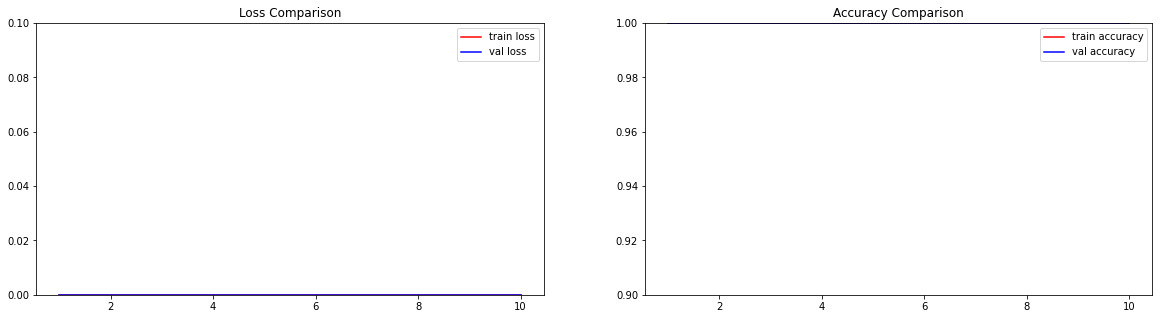


Run 10/10
Epoch 1/10
 4/38 [==>...........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000 

38/38 [==============================] - 2s 32ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
38/38 [==============================] - 1s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
38/38 [==============================] - 1s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
38/38 [==============================] - 1s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
38/38 [==============================] - 1s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
38/38 [==============================] - 1s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
38/38 [==============================] - 1s 24ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.

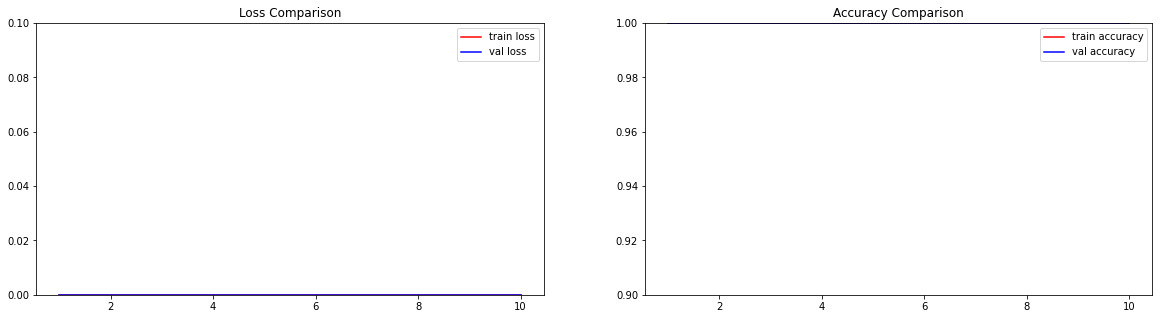

In [22]:
results_list = []
num_epochs = 10
model = define_model()
model = compile_model(model)

for i in range(len(X_train_split)):
    if i != 0:
        print()
        del model
        tf.keras.backend.clear_session()
        gc.collect()
        model = tf.keras.models.load_model(save_path_h5)
        model = compile_model(model)
    print(f"Run {i+1}/{len(X_train_split)}")


    results = model.fit(X_train_split[i], y_train_split[i], batch_size=2, epochs=num_epochs, 
                        validation_data=(X_test, y_test), shuffle=True, verbose=1,
                        callbacks=[SaveModelCallback(i)])
    results_list.append(results)

    display_accuracy(results)

### Accuracy over all epochs

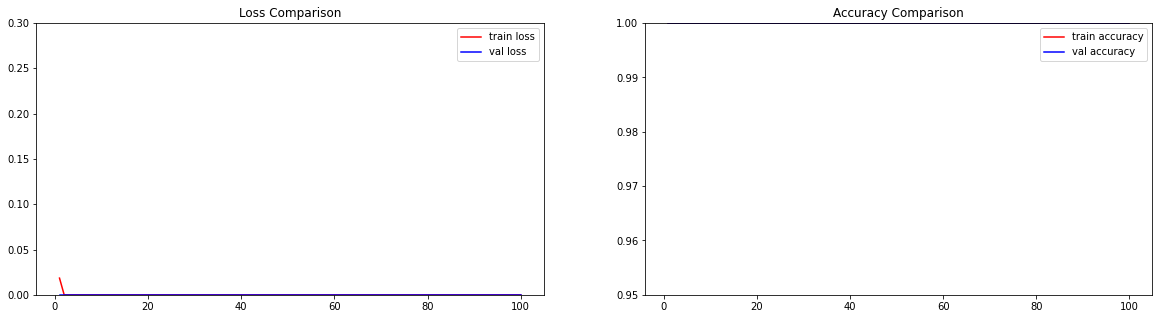

In [23]:
merged_results = pd.concat([pd.DataFrame(result.history) for result in results_list], ignore_index=True)

x = np.arange(1,len(merged_results)+1)
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(x, merged_results["loss"], color='r', label = 'train loss')
axis[0].plot(x, merged_results["val_loss"], color='b', label = 'val loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[0].set_ylim([0,0.3])
axis[1].plot(x, merged_results["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(x, merged_results["val_accuracy"], color='b', label = 'val accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()
axis[1].set_ylim([0.95, 1])
plt.show()